In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
# %matplotlib notebook

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

import superscreen as sc

from huber_squid import huber_squid, huber_geometry

In [2]:
device = huber_squid()

In [3]:
device.layers["BE"].london_lambda = 100

In [4]:
device.make_mesh(min_triangles=12000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 12437 triangles.
INFO:superscreen.device:Finished generating mesh with 6344 points and 12437 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


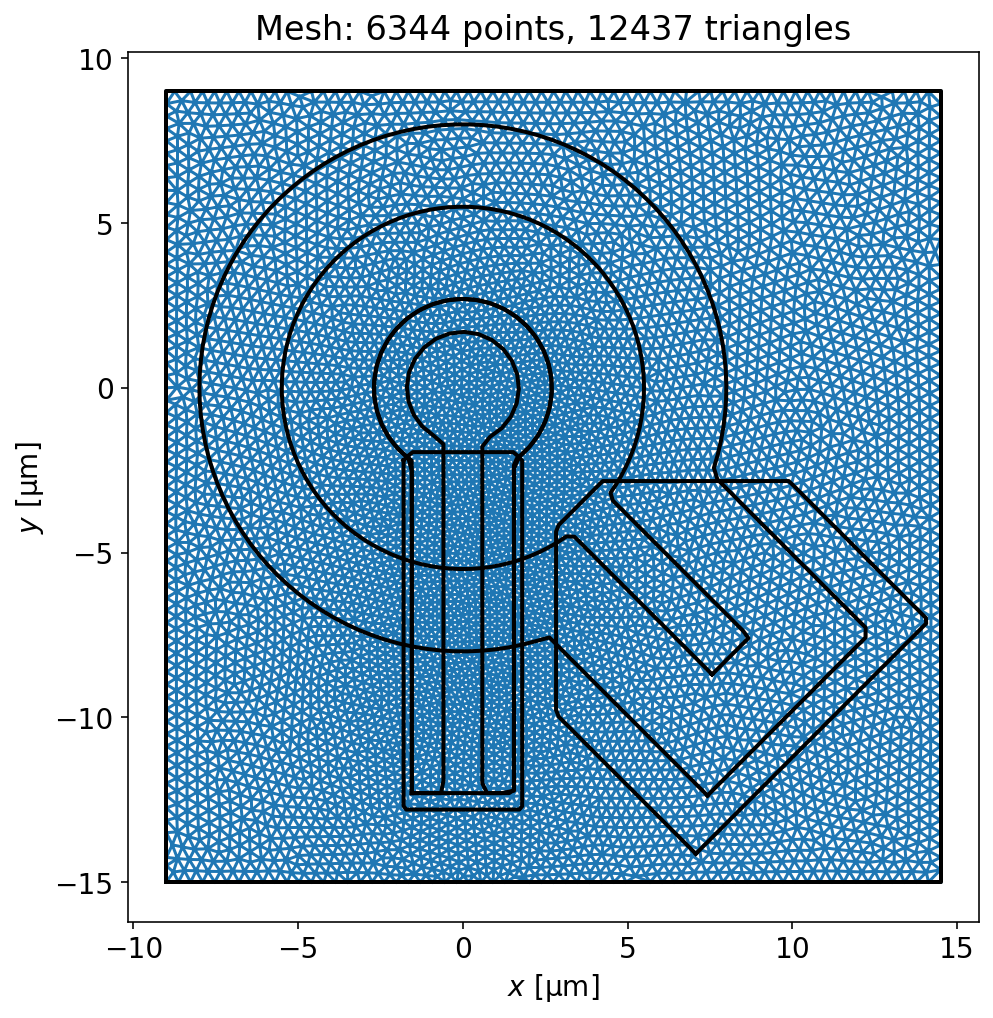

In [5]:
ax = device.plot_mesh()
ax = device.plot_polygons(ax=ax, color='k', lw=2, legend=False)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [6]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=6,
    coupled=True,
)
solution = solutions[-1]

INFO:superscreen.brandt:Calculating W2 response to applied field.
INFO:superscreen.brandt:Calculating W1 response to applied field.
INFO:superscreen.brandt:Calculating BE response to applied field.
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (1/6).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (1/6).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (1/6).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (1/6).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (1/6).
INFO:superscreen.brandt:Calculating screening field at BE from W1 (1/6).
INFO:superscreen.brandt:Calculating W2 response to applied field and screening field from other layers (1/6).
INFO:superscreen.brandt:Calculating W1 response to applied field and screening field from other layers (1/6).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (1/6).
INFO:superscreen.brandt:Calculatin

In [7]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [8]:
display(df)

,fc,fc_shield,pl,pl_shield,fc_center,bounding_box,pl_hull
Iteration,,,,,,,
0,6.879766,0.000000,0.000000,0.000000,3.898601,0.000000,0.000000
1,6.879766,0.010166,0.384075,0.061705,3.898601,3.395118,1.147109
2,4.833343,0.015313,0.340332,0.080279,2.710926,3.344817,0.977199
3,4.835867,0.017047,0.331789,0.082587,2.731541,3.328043,0.929445
4,4.822418,0.017289,0.329005,0.083272,2.721193,3.326224,0.923094
5,4.823440,0.017393,0.328413,0.083403,2.723286,3.325480,0.921234
6,4.822520,0.017408,0.328227,0.083463,2.722495,3.325372,0.920836


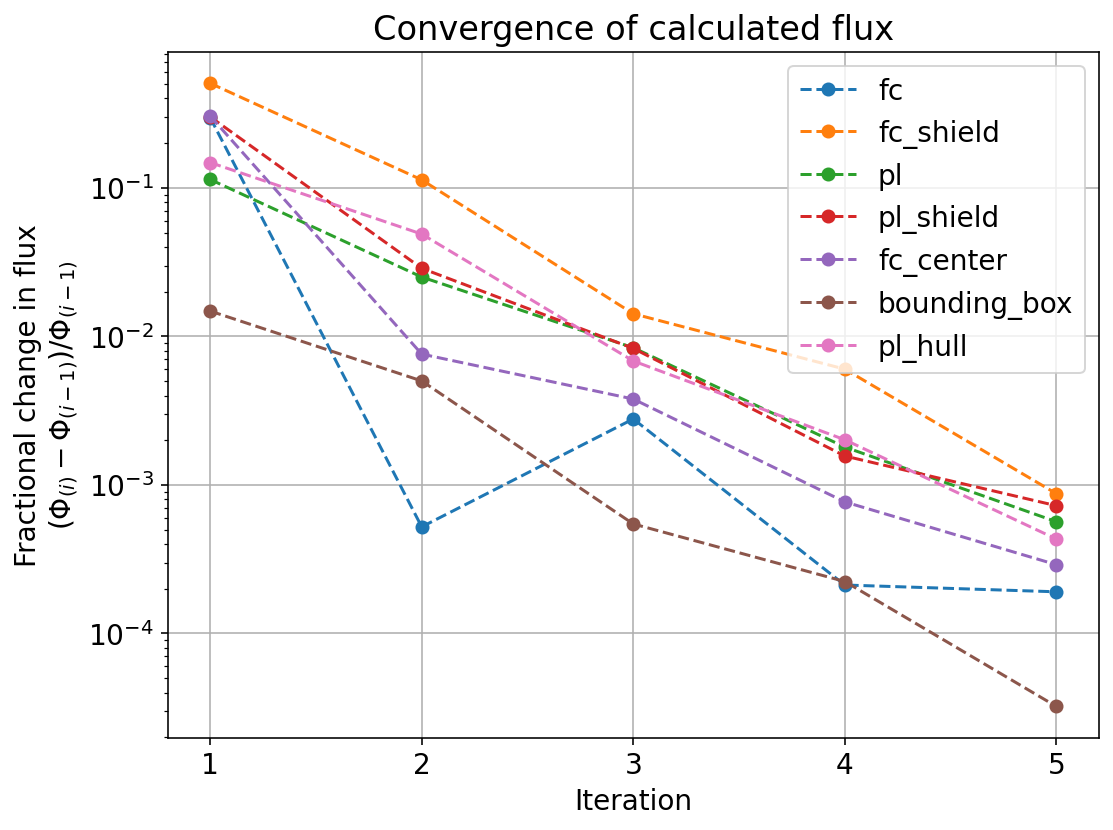

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} -\\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_yscale("log")
ax.set_xticks(np.arange(len(ys)) + 1)
ax.legend(loc=0)
ax.set_title("Convergence of calculated flux")
fig.tight_layout()

In [10]:
flux = solutions[-1].polygon_flux()
I_circ = device.ureg(circulating_currents['fc_center'])
# print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(
    f"Calculated FC - PL mutual inductance:"
    f"\n\t{(flux['pl_hull'] / I_circ).to('Phi_0/A'):.3f~P} = "
    f"{(flux['pl_hull'] / I_circ).to('pH'):.3f~P}"
)

Calculated FC - PL mutual inductance:
	920.836 Φ_0/A = 1.904 pH


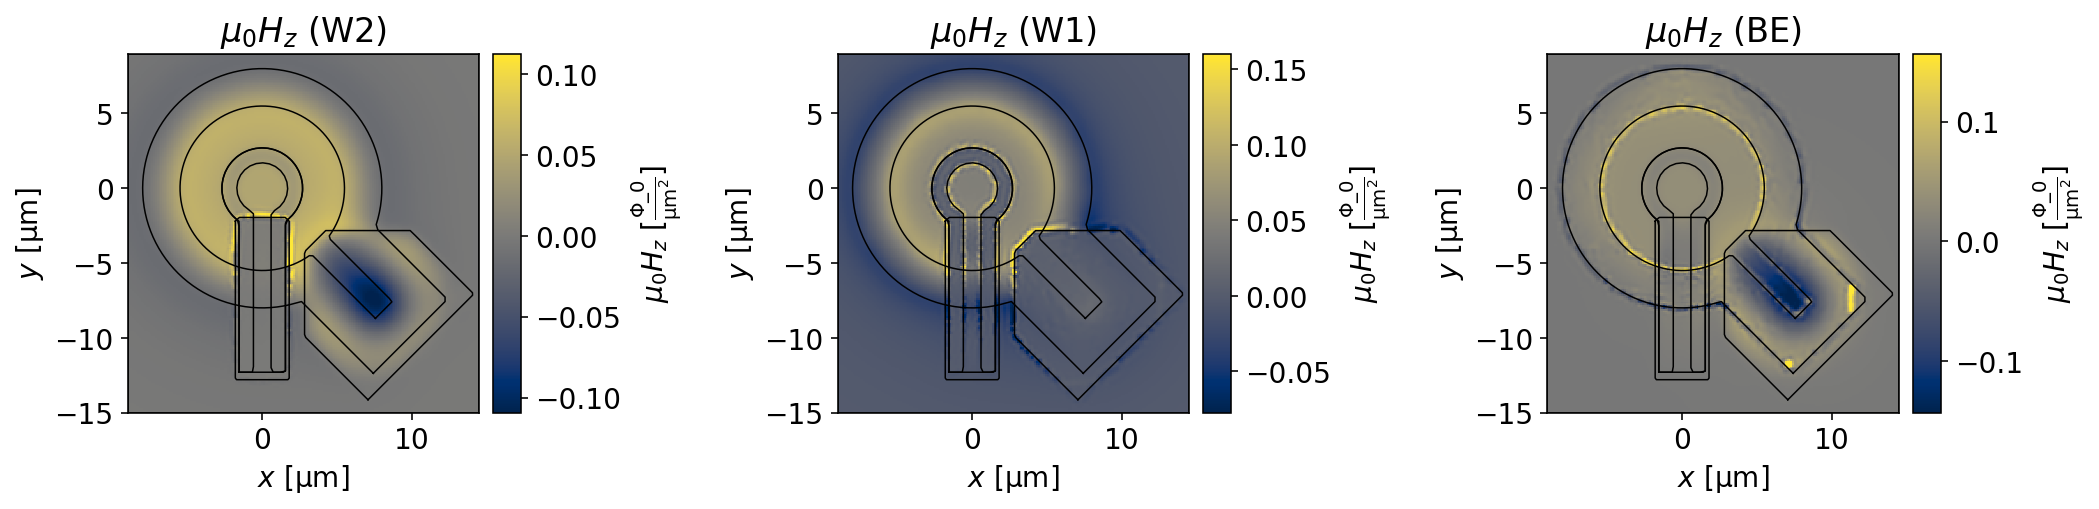

In [11]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_fields(
        solution,
        units="Phi_0/um**2",
        figsize=(15,5),
        auto_range_cutoff=0.1,
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)

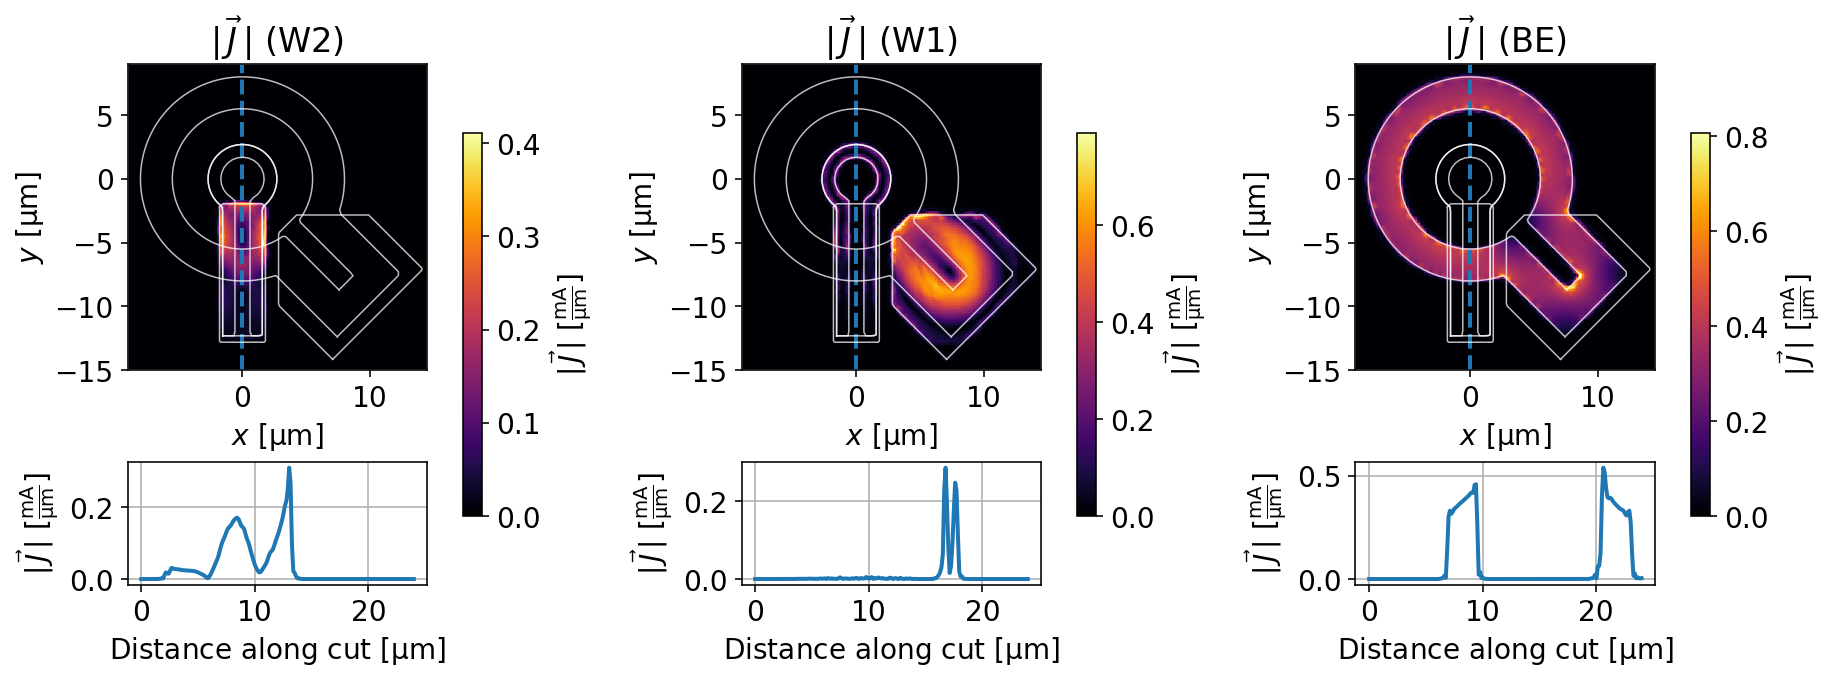

In [12]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_currents(
        solution,
        figsize=(13, 5),
        streamplot=False,
        units="mA/um",
        cross_section_xs=0,
        cross_section_angle=0,
    )
    for ax in axes:
        device.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)

In [13]:
img = plt.imread("huber-image.png")
scale = np.where(img[385][:, 0] == 1)[0].size / 5 # pixels per micron

origin = x0, y0 = (465, 610)

In [14]:
polygons = {
    name: scale * sc.geometry.rotate(points, 0)
    for name, points in huber_geometry(interp_points=101).items()
}

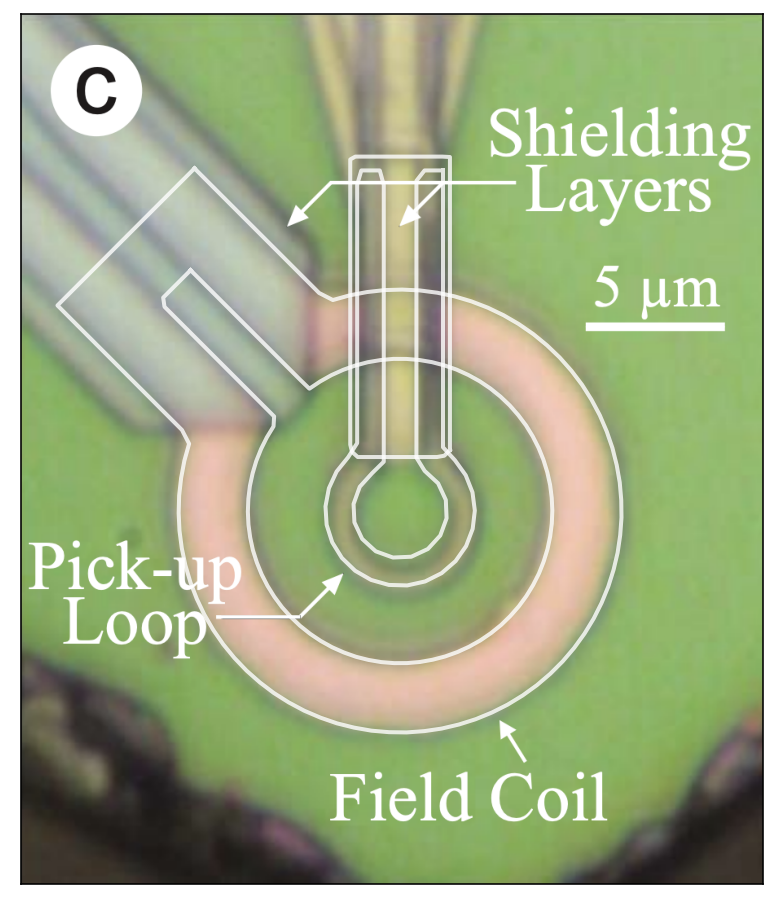

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
im = ax.imshow(img[:-200])
ax.set_yticks([])
ax.set_xticks([])

for name, points in polygons.items():
    if name in ["pl_hull", "fc_shield"]:
        continue
    xs, ys = points.T
    xs = -xs
    xs = xs + x0
    ys = ys + y0
    ax.plot(xs, ys, color='w', alpha=0.8, lw=2)
    
_ = ax.set_xlim(0, img.shape[1]-1)